## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial import distance
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import cluster, metrics, datasets
import seaborn as sns 
# importing more models that I may need.


# For 3D plots
import plotly
plotly.tools.set_credentials_file(username='lawrencefsoto', api_key='Sg9BCjSVRVWL5jklUegz')


import plotly.plotly as py
import plotly.graph_objs as go

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 700) # want to see more rows and columns

## Reading in my Data

In [2]:
df = pd.read_csv('../Scraping/clean_season_17_18')
df.shape #checking shape

(372, 44)

In [3]:
# checking to see if all the numerical columns are not strings
# not sure what happened here because I didn't change my data from objects to floats either way it works.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 44 columns):
Name    372 non-null object
2P      372 non-null float64
2P%     372 non-null float64
2PA     372 non-null float64
3P      372 non-null float64
3P%     372 non-null float64
3PA     372 non-null float64
AST     372 non-null float64
Age     372 non-null int64
BLK     372 non-null float64
DRB     372 non-null float64
DRtg    372 non-null int64
FG      372 non-null float64
FG%     372 non-null float64
FGA     372 non-null float64
FT      372 non-null float64
FT%     372 non-null float64
FTA     372 non-null float64
G       372 non-null int64
GS      372 non-null int64
MP      372 non-null float64
ORB     372 non-null float64
ORtg    372 non-null int64
PF      372 non-null float64
PTS     372 non-null float64
Pos     372 non-null object
STL     372 non-null float64
TOV     372 non-null float64
TRB     372 non-null float64
Tm      372 non-null object
AST%    372 non-null float64
BLK%    3

In [4]:
df =df[df['G']>=40] # going to take out players that have less than 40 games out.
df.set_index('Name', inplace=True) # setting Name as index

In [5]:
pg = df[df['Pos']=='PG'] # going to only cluster PG

pg = pg.reindex(sorted(pg.columns), axis=1) # sorting the columns for pg. important to sort columns if you want 
# to pickle your model for another use.

pg.head() # sanity check

,2P,2P%,2PA,3P,3P%,3PA,AST,AST%,Age,BLK,BLK%,BPM,DBPM,DRB,DRB%,DRtg,FG,FG%,FGA,FT,FT%,FTA,G,GS,MP,OBPM,ORB,ORB%,ORtg,PER,PF,PTS,Pos,STL,STL%,TOV,TOV%,TRB,TRB%,TS%,Tm,USG%,VORP
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D.J. Augustin,3.6,0.485,7.5,3.2,0.419,7.6,8.0,24.4,30,0.0,0.0,-0.9,-2.5,3.6,8.2,113,6.8,0.452,15.0,4.6,0.868,5.3,75,36,1760.0,1.5,0.8,1.9,116,15.4,2.6,21.3,PG,1.5,1.5,3.4,16.5,4.5,5.0,0.615,ORL,18.6,0.5
Lonzo Ball,3.0,0.420,7.2,2.4,0.305,7.9,10.1,29.2,20,1.2,2.0,1.7,2.5,7.8,17.3,106,5.5,0.360,15.2,0.9,0.451,1.9,52,50,1780.0,-0.8,1.9,4.2,97,12.5,3.1,14.2,PG,2.4,2.4,3.7,18.6,9.7,10.8,0.444,LAL,17.4,1.7
J.J. Barea,5.9,0.499,11.8,3.6,0.367,9.8,13.6,45.1,33,0.1,0.2,0.1,-2.3,5.8,13.4,112,9.5,0.439,21.6,2.5,0.784,3.2,69,10,1603.0,2.4,0.5,1.0,109,17.8,2.6,25.1,PG,1.1,1.1,4.5,16.3,6.3,7.0,0.545,DAL,24.9,0.8
Eric Bledsoe,7.4,0.545,13.5,2.7,0.347,7.7,7.9,25.7,28,0.9,1.5,2.1,-0.3,5.0,11.7,108,10.0,0.473,21.2,5.4,0.795,6.8,74,74,2322.0,2.4,1.1,2.6,108,19.7,4.0,28.2,PG,3.2,3.2,4.6,16.1,6.1,7.1,0.582,TOT,26.1,2.4
Malcolm Brogdon,6.3,0.532,11.9,2.2,0.385,5.6,5.3,16.3,25,0.5,0.8,-1.3,-1.9,4.6,10.8,113,8.5,0.485,17.5,2.6,0.882,3.0,48,20,1436.0,0.6,0.8,1.9,112,14.3,4.4,21.7,PG,1.4,1.4,2.3,10.9,5.4,6.4,0.578,MIL,19.1,0.2


## Clustering PG w/ Kmeans

#### Scaling Required

In [6]:
X = pg.drop(columns=['G','GS','MP','Age','Pos','Tm']) ## took out columns that don't matter to the model
ss = StandardScaler()
pg_scaled = ss.fit_transform(X)

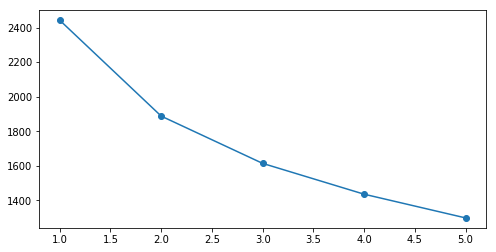

In [7]:
## looking best cluster with inertia for Kmeans first before Modeling out my PG's

cluster_range = range( 1, 6 )
cluster_errors = []

for num_clusters in cluster_range:
    pgclusters = KMeans(num_clusters)
    pgclusters.fit(pg_scaled)
    cluster_errors.append(pgclusters.inertia_)

clusters_df = pd.DataFrame({ 'num_clusters':cluster_range, 'cluster_errors': cluster_errors })

plt.figure(figsize=(8,4))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );

In [8]:
# From this graph I am looking for an elbow and it seems that 3 clusters may be best for this model.

In [9]:
# Want to check how the cluster performs w/ labels, centriod, intertia and silhouette_score

def performance(data, n_clusters): 
    
    performance = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    performance = performance.fit(data)
    labels = performance.labels_
    centroids = performance.cluster_centers_
    inertia = performance.inertia_
    sil_score = metrics.silhouette_score(data, performance.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }

    return data_dictionary

In [10]:
performance(pg_scaled,3) # using 3 cluster and seeing what it returns.

{'labels': array([1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1],
       dtype=int32),
 'centroids': array([[ 1.13051473,  0.13345452,  1.0886183 , -0.92011511, -1.56147897,
         -0.84826385,  0.92329162,  0.97588865,  1.2972767 ,  1.29999696,
          1.31613761,  2.5886891 ,  2.83874651,  2.81852972, -1.94573067,
          0.51751586,  0.42285241,  0.38884476,  0.06395147, -2.02653936,
          0.53431696,  0.18087609,  2.90207106,  2.86708048, -0.37787035,
          0.76398891, -0.1758373 ,  0.18898982,  1.15733098,  1.15733098,
          1.32577505,  0.86110277,  3.01553761,  2.99965756, -0.58035277,
          0.53538538,  1.63115379],
        [-0.32982959, -0.18893514, -0.28883801, -0.2408703 ,  0.02235856,
         -0.25324569, -0.25062152, -0.33951791, -0.10516872, -0.0915346 ,
         -0.41275906, -0.144177

In [11]:
# this will plot my silhouette score so I can better visualize my clusters from ranges a-b

def find_best_cluster(data,a,b):
    scores = []
    for i in range(a,b):
        i_clusters = performance(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Measuring Silhouette Score to Find Best Cluster""")
    print ("best silhouette score:", np.max(scores))

best silhouette score: 0.2411062943840017


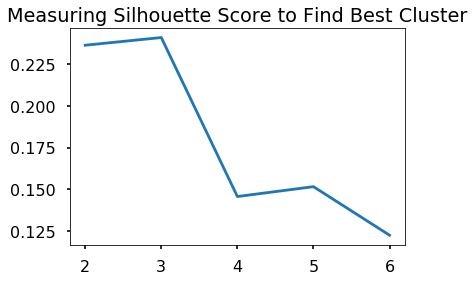

In [12]:
find_best_cluster(pg_scaled,2,7)

In [13]:
# from silhoutte score it seems that 3 is still best cluster for PG will ultimately be using 3 clusters.

## Picking Cluster and Modeling

In [14]:
pgk= KMeans(n_clusters=3, random_state=42)
pgk.fit(pg_scaled)
pg['pg_cluster'] = pgk.labels_
Counter(pgk.labels_) # counter sees how many in each cluster

Counter({1: 48, 0: 4, 2: 14})

In [15]:
pg[pg['pg_cluster']==0] ## checking cluster 0

,2P,2P%,2PA,3P,3P%,3PA,AST,AST%,Age,BLK,BLK%,BPM,DBPM,DRB,DRB%,DRtg,FG,FG%,FGA,FT,FT%,FTA,G,GS,MP,OBPM,ORB,ORB%,ORtg,PER,PF,PTS,Pos,STL,STL%,TOV,TOV%,TRB,TRB%,TS%,Tm,USG%,VORP,pg_cluster
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Lonzo Ball,3.0,0.420,7.2,2.4,0.305,7.9,10.1,29.2,20,1.2,2.0,1.7,2.5,7.8,17.3,106,5.5,0.360,15.2,0.9,0.451,1.9,52,50,1780.0,-0.8,1.9,4.2,97,12.5,3.1,14.2,PG,2.4,2.4,3.7,18.6,9.7,10.8,0.444,LAL,17.4,1.7,0
Dejounte Murray,7.6,0.454,16.7,0.3,0.265,1.0,6.7,20.2,21,0.9,1.5,1.2,3.4,10.1,22.4,101,7.8,0.443,17.7,3.0,0.709,4.3,81,48,1743.0,-2.2,3.2,7.0,99,15.1,4.4,19.0,PG,2.8,2.8,3.9,16.6,13.3,14.6,0.485,SAS,20.7,1.4,0
Ben Simmons,9.6,0.551,17.4,0.0,0.000,0.2,11.6,37.4,21,1.2,2.1,4.6,3.6,9.0,19.5,102,9.6,0.545,17.6,3.4,0.560,6.0,81,81,2732.0,1.0,2.6,5.9,111,20.0,3.7,22.5,PG,2.5,2.5,4.9,19.5,11.6,13.0,0.557,PHI,22.3,4.6,0
Russell Westbrook,11.2,0.485,23.2,1.7,0.298,5.6,14.0,49.8,29,0.3,0.6,8.2,3.1,11.1,25.7,104,12.9,0.449,28.7,7.1,0.737,9.6,80,80,2914.0,5.1,2.6,5.6,109,24.7,3.4,34.5,PG,2.5,2.5,6.5,16.4,13.7,15.3,0.524,OKC,34.1,7.5,0


In [16]:
# double checking my model predicting for one of my players.

lonzo = pd.DataFrame(pg.loc['Lonzo Ball'][:43]).T.drop(columns=['Age','G','GS','MP','Pos','Tm'])
lonzo_scaled=ss.transform(lonzo)
pgk.predict(lonzo_scaled)

array([0], dtype=int32)

In [17]:
# checks the distance from each cluster and why it got clustered to cluster 0

for i in range(0,3):
    print('dist between evan_scaled and cluster', i, ':', distance.euclidean(lonzo_scaled, pgk.cluster_centers_[i]))

dist between evan_scaled and cluster 0 : 7.580402359781435
dist between evan_scaled and cluster 1 : 8.734419043164749
dist between evan_scaled and cluster 2 : 11.09412064862857


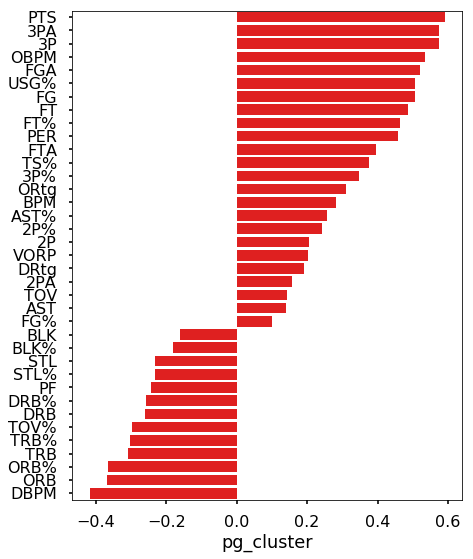

In [18]:
 ## want to see correlation of each feature to see how each feature effected the cluster

pg_corr = pg.drop(columns=['Age','G','GS','MP','Pos','Tm']) 
pg_corr.corr()
corr=pg_corr.corr() 
corr = corr.sort_values('pg_cluster',ascending=False)


plt.figure(figsize=(7,9))
sns.barplot(corr.pg_cluster[1:], corr.index[1:], color='r')
plt.show();

In [19]:
## from this bar graph it seems that PTS, 3PA are positive correlation for pg_clusters while DBPM strong negative
## correlation may be using those 3 features to plot my 3D graph.

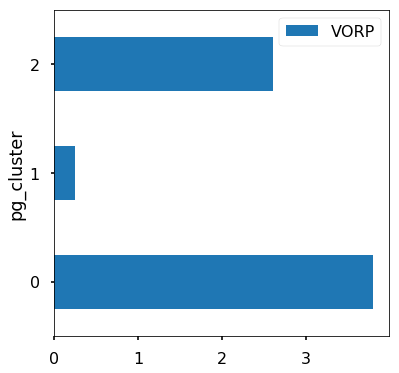

In [20]:
## VORP is Value Over Replacement Player shows which cluster is most valuable

pg_2p= pg[['VORP','pg_cluster']]
pg_2p.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(6,6));

In [21]:
## from this graph clusters 0 and 2 are more valuable than 1

In [22]:
pg_corr.drop(columns=['ORtg', 'DRtg'],inplace=True)

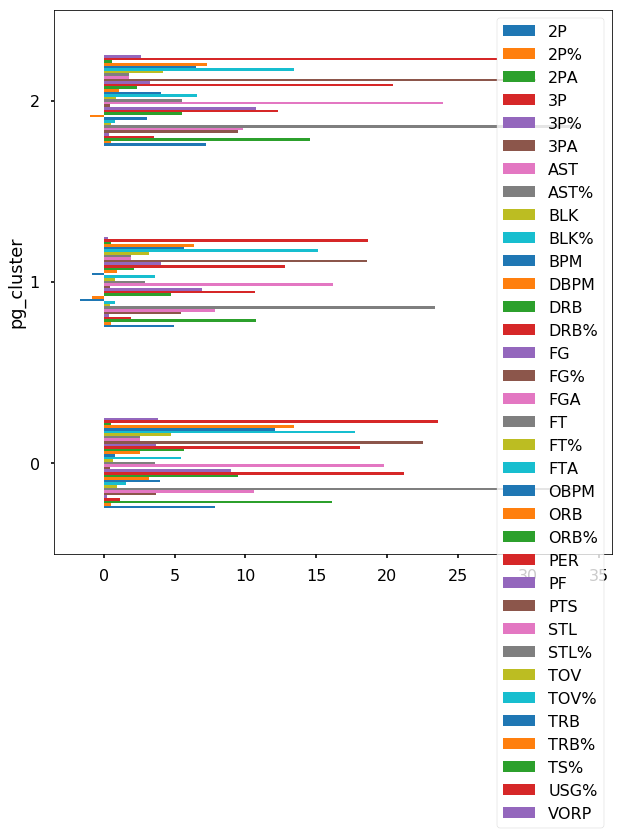

In [23]:
pg_corr.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(10,10)); ## hard to interpret going to split it up.

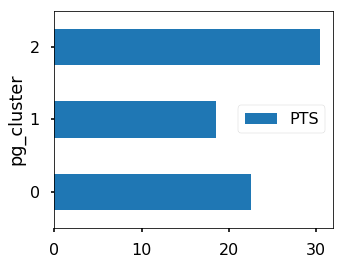

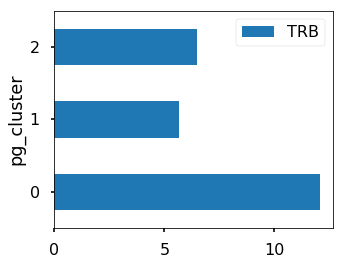

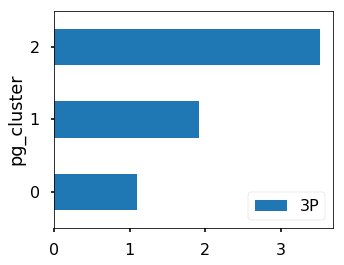

In [24]:
## Checking

test1= pg[['PTS','pg_cluster']] 
test1.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(5,4));

test2= pg[['TRB','pg_cluster']] 
test2.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(5,4));

test3= pg[['3P','pg_cluster']] 
test3.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(5,4));

In [25]:
## pg2 highest scorers, 3 point attempts and makes, offensive plus minus is higest
## pg0 highest rebounder, defensive plus minus highest

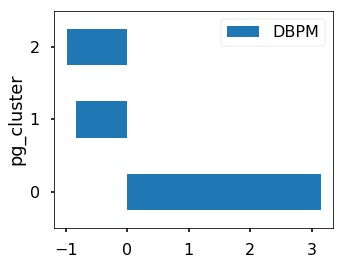

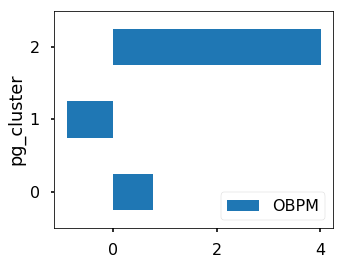

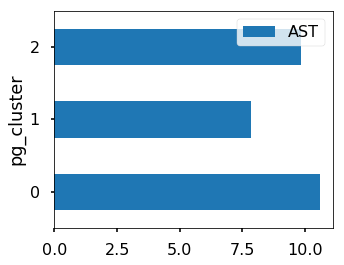

In [26]:
test1= pg[['DBPM','pg_cluster']] 
test1.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(5,4));

test2= pg[['OBPM','pg_cluster']] 
test2.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(5,4));

test3= pg[['AST','pg_cluster']] 
test3.groupby(['pg_cluster']).mean().plot(kind='barh', figsize=(5,4));

In [27]:
pg[pg['pg_cluster']==1].head()

,2P,2P%,2PA,3P,3P%,3PA,AST,AST%,Age,BLK,BLK%,BPM,DBPM,DRB,DRB%,DRtg,FG,FG%,FGA,FT,FT%,FTA,G,GS,MP,OBPM,ORB,ORB%,ORtg,PER,PF,PTS,Pos,STL,STL%,TOV,TOV%,TRB,TRB%,TS%,Tm,USG%,VORP,pg_cluster
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D.J. Augustin,3.6,0.485,7.5,3.2,0.419,7.6,8.0,24.4,30,0.0,0.0,-0.9,-2.5,3.6,8.2,113,6.8,0.452,15.0,4.6,0.868,5.3,75,36,1760.0,1.5,0.8,1.9,116,15.4,2.6,21.3,PG,1.5,1.5,3.4,16.5,4.5,5.0,0.615,ORL,18.6,0.5,1
Malcolm Brogdon,6.3,0.532,11.9,2.2,0.385,5.6,5.3,16.3,25,0.5,0.8,-1.3,-1.9,4.6,10.8,113,8.5,0.485,17.5,2.6,0.882,3.0,48,20,1436.0,0.6,0.8,1.9,112,14.3,4.4,21.7,PG,1.4,1.4,2.3,10.9,5.4,6.4,0.578,MIL,19.1,0.2,1
Jose Calderon,2.6,0.545,4.7,2.4,0.464,5.2,6.3,17.4,36,0.1,0.2,-1.9,-2.0,3.8,8.5,115,5.0,0.503,9.9,1.3,0.800,1.6,57,32,914.0,0.1,0.8,1.7,122,11.3,4.3,13.7,PG,1.4,1.4,2.2,17.1,4.5,5.2,0.643,CLE,11.6,0.0,1
Michael Carter-Williams,3.6,0.365,9.9,0.8,0.237,3.4,6.8,19.4,26,1.3,2.3,-0.6,2.0,5.9,13.3,107,4.4,0.332,13.4,4.3,0.820,5.2,52,2,835.0,-2.6,2.2,4.7,98,10.8,5.8,14.0,PG,2.6,2.6,3.0,16.2,8.1,8.9,0.446,CHO,16.6,0.3,1
Mario Chalmers,4.1,0.456,9.0,1.9,0.277,6.8,7.0,21.5,31,0.5,0.9,-2.7,-0.5,5.1,12.0,110,6.0,0.379,15.8,4.2,0.855,4.9,66,10,1421.0,-2.2,0.5,1.0,96,10.4,6.4,18.0,PG,2.8,2.8,4.2,18.8,5.6,6.4,0.503,MEM,19.6,-0.3,1


## Conclusion

All PG have strong assist #numbers

PG0 - Defensive PG with strong rebounding skills, doesn't take much 3's 
<br/> New-Protype Defensive PG- Lonzo,Murray,Ben Simmons, Russel Westbrook

PG1 - Fill ins aren't strong in anything particular
<br/> Normal PG/ Bench - Mario Chalmers, Darren Collison,Raymond Felton, De'Aaron Fox

PG2 - Offensive PG with strong 3 points makes and attempts, highest scoreers
<br/> Offensive PG - Eric Bledsoe, Steph Curry, Tyreke Evans, Kyrie Irving, Damian Lillard

Value
<br/>PG0 > PG2 > PG1

In [ ]:
## Plotting on 3D to see the cluster differences

trace1 = go.Scatter3d(
    x=pg['PTS'],
    y=pg['3PA'],
    z=pg['DBPM'],
    mode='markers',
    marker=dict(
        size=12,
        color=pg['pg_cluster'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
## really nice clustering you can see the differences in each cluster.

In [ ]:
## Uncomment to pickle model

##from sklearn.externals import joblib
##joblib.dump(ss, './pg_scaler.pk1')
##joblib.dump(pgk, './pg_kmeans.pk1')

In [ ]:
## saving my file
pg.to_csv('./pg_cluster_17_18')